In [1]:
import os
from time import time
import numpy as np
import sys
sys.path.append('../')

from utils.codification_cnn import CNNLayer, NNLayer, ChromosomeCNN, FitnessCNN, FitnessCNNParallel
from utils.datamanager import DataManager
from utils.codification_skipc import ChromosomeSkip, FitnessSkip, Connections
from GA.parentSelector.parentSelector import RandomParentSelector, TournamentSelection, LinealOrder, WheelSelection
from GA.geneticAlgorithm import GenerationalGA


Using TensorFlow backend.


In [2]:
# Chromosome parameters
mutation_rate = 0.05
mutation_rate_1 = mutation_rate * 2
ChromosomeSkip.grow_prob = mutation_rate
ChromosomeSkip.decrease_prob = mutation_rate

CNNLayer.k_prob = mutation_rate
CNNLayer.filter_prob = mutation_rate_1
CNNLayer.act_prob = mutation_rate
CNNLayer.drop_prob = mutation_rate_1
CNNLayer.maxpool_prob = mutation_rate

NNLayer.units_prob = mutation_rate_1
NNLayer.act_prob = mutation_rate
NNLayer.drop_prob = mutation_rate_1

CNNLayer.filters_lim = 128

'''
data_folder = '../../datasets'
command = 'python3 ./train_gen.py'
verbose = 0
experiments_folder = '../../exps'
gpus = 2
skip = True

'''
data_folder = '/home/daniel/datasets/MNIST_variations'
command = 'python ./../train_gen.py'
verbose = 1
experiments_folder = '../exps'
gpus = 1
skip = 1

In [3]:
experiments_folder = experiments_folder
os.makedirs(experiments_folder, exist_ok=True)

if skip:
    fitness_cnn = FitnessSkip()
else:
    fitness_cnn = FitnessCNN()

l = CNNLayer(32, (3,3), 'relu', 0, False)
l2 = CNNLayer(64, (3,3), 'relu', 0.25, True)
l3 = NNLayer(128, 'relu', 0.5)
c = ChromosomeCNN([l, l2], [l3], fitness_cnn)
if skip:
    c = ChromosomeSkip(c.cnn_layers, c.nn_layers, Connections.random_connections(len(c.cnn_layers)))
    
# dataset params:
data_folder = data_folder
classes = []

# genetic algorithm params:
parents_selector_key = 'tournament'
num_parents = 0.25 
generations = 2
population = 4
train_time = 10
maximize_fit = False
stat_val = True
save_progress = True
age_survivors_rate = 0.05
precision_val = True
precision_individuals = 1

ps = {'random':RandomParentSelector(), 'lineal':LinealOrder(), 'wheel':WheelSelection(), 
      'tournament':TournamentSelection(population//4)}
p = ps[parents_selector_key]

# Fitness params
epochs = 2
batch_size = 128
verbose = verbose
redu_plat = False
early_stop = 15
warm_up_epochs= 0
base_lr = 0.001
smooth = 0.1
cosine_dec = True
lr_find = False
precise_eps = 5

datasets = ['MB', 'MBI', 'MRB', 'MRD', 'MRDBI']
datasets = ['MRDBI']

In [26]:
class ChromosomeSkipLr_UB(ChromosomeSkip):
    def __init__(self, cnn_layers=None, nn_layers=None, connections=None,fitness=None):
        super().__init__(cnn_layers=cnn_layers, nn_layers=nn_layers, connections=connections,
                         fitness=fitness)
    @staticmethod
    def random_individual():
        max_init_cnn_layers = int(ChromosomeCNN.max_layers['CNN'] + 1)
        max_init_nn_layers = int(ChromosomeCNN.max_layers['NN'] + 1)
        n_cnn = np.random.randint(0, max_init_cnn_layers)
        n_nn = np.random.randint(0, max_init_nn_layers)
        cnn_layers = [ChromosomeCNN.layers_types['CNN'].random_layer() for _ in range(n_cnn)]
        nn_layers = [ChromosomeCNN.layers_types['NN'].random_layer() for _ in range(n_nn)]
        n_blocks = len(cnn_layers)
        new_connections = Connections.random_connections(n_blocks)
        return ChromosomeSkipLr_UB(cnn_layers=cnn_layers,
                              nn_layers=nn_layers,
                              connections=new_connections)
    
    def mutate_layers(self, this_layers, type_):
        for i in range(len(this_layers)):
            this_layers[i].mutate()
        if np.random.rand() < self.grow_prob:
            if len(this_layers) == 0:
                this_layers.append(self.layers_types[type_].random_layer())
            else:
                # Choose a random layer, copy it, mutate it and add it next to the original one
                index_to_add = int(np.random.randint(len(this_layers)))
                layer_to_copy = this_layers[index_to_add]
                new_layer = layer_to_copy.self_copy()
                new_layer.mutate()
                this_layers.insert(index_to_add + 1, new_layer)
                if type_ == 'CNN':
                    self.connections.add_connection(index_to_add)
        elif np.random.rand() < self.decrease_prob and len(this_layers) > 0:
            index_to_delete = int(np.random.randint(len(this_layers)))
            this_layers.pop(index_to_delete)
            if type_ == 'CNN':
                self.connections.delete_connection(index_to_delete)
                
c = ChromosomeSkipLr_UB.random_individual()
print(c)

CNN|F:59|K:(3,7)|A:tanh|D:0.005|M:0
CNN|F:123|K:(7,5)|A:sigmoid|D:0.293|M:0
CNN|F:93|K:(1,3)|A:prelu|D:0.113|M:0
CNN|F:87|K:(7,1)|A:elu|D:0.858|M:0
CNN|F:117|K:(3,7)|A:tanh|D:0.742|M:1
CNN|F:63|K:(1,1)|A:leakyreLu|D:0.056|M:0
CNN|F:13|K:(7,1)|A:leakyreLu|D:0.416|M:0
CNN|F:14|K:(3,5)|A:leakyreLu|D:0.509|M:0
CNN|F:65|K:(5,5)|A:sigmoid|D:0.104|M:0
NN|U:141|A:leakyreLu|D:0.209
NN|U:732|A:prelu|D:0.853
1
01
010
1111
10011
001101
1110011
11011011




EVOLVING IN DATASET MRDBI ...

(9600, 28, 28, 1) train samples
(2400, 28, 28, 1) validation samples
(50000, 28, 28, 1) test samples
Number of individuals eliminated by age: 0
Genetic algorithm params
Number of generations: 2
Population size: 4
Folder to save: ../exps/MRDBI/genetic/0_2019-07-19-15:22/GA_experiment
num parents: 1
offspring size: 3

Creating Initial population

Start evolution process...

1) best fit: 0.498 in batch time: 2.71 mins
Current winner:
CNN|F:87|K:(3,5)|A:relu|D:0.667|M:1

Saving... Elapsed saved time: 0.001
2) best fit: 0.498 in batch time: 3.92 mins
Current winner:
CNN|F:87|K:(3,5)|A:relu|D:0.667|M:1

Saving... Elapsed saved time: 0.001
Making statistical validation
Benchmark Val score: 0.4114. Winner Val score: 0.5694
t = 28.3093, p = 0.0000
Benchmark Test score: 0.4035. Winner Test score: 0.5012
t = 18.0002, p = 0.0001
Best Gen -> 
CNN|F:87|K:(3,5)|A:relu|D:0.667|M:1

With Fitness (val): 0.4979 and (test): 0.5012


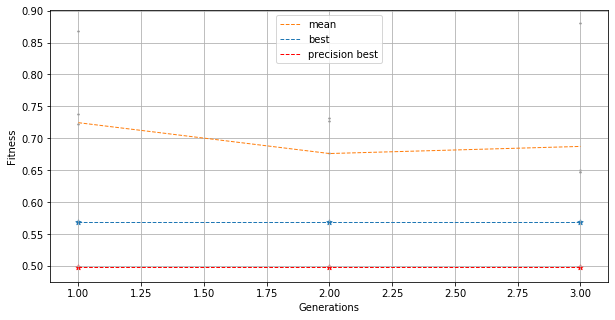

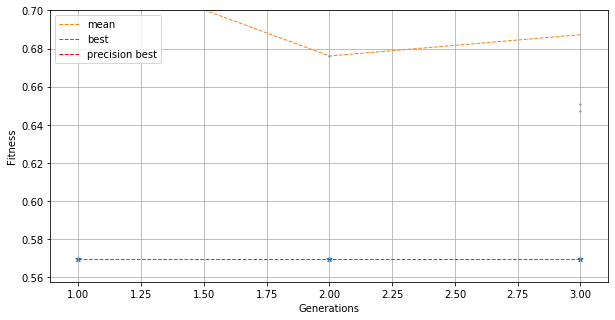

Total elapsed time: 518.128


In [7]:
for dataset in datasets:
    print("\nEVOLVING IN DATASET %s ...\n" % dataset)
    exp_folder = os.path.join(experiments_folder, dataset)
    folder = os.path.join(exp_folder, 'genetic')
    fitness_folder = exp_folder
    fitness_file = os.path.join(fitness_folder, 'fitness_example')   
    os.makedirs(folder, exist_ok=True)

    # Load data
    dm = DataManager(dataset, clases=classes, folder_var_mnist=data_folder)
    data = dm.load_data()
    fitness_cnn.set_params(data=data, verbose=verbose, batch_size=batch_size, reduce_plateau=redu_plat,
                   epochs=epochs, cosine_decay=cosine_dec, early_stop=early_stop, 
                   warm_epochs=warm_up_epochs, base_lr=base_lr, smooth_label=smooth, find_lr=lr_find,
                   precise_epochs=precise_eps)

    fitness_cnn.save(fitness_file)

    del dm, data
    
    fitness = FitnessCNNParallel()
    fitness.set_params(chrom_files_folder=fitness_folder, fitness_file=fitness_file, max_gpus=gpus,
                   fp=32, main_line=command)
    
    generational = GenerationalGA(fitness=fitness, num_parents=num_parents, chromosome=c, parent_selector=p,
                              generations=generations, num_population=population, maximize_fitness=maximize_fit, 
                              training_hours=train_time, folder=folder, statistical_validation=stat_val,
                              save_progress=save_progress, age_survivors_rate=age_survivors_rate,
                              precision_val=precision_val, precision_individuals=precision_individuals)
    
    ti_all = time()
    winner, best_fit, ranking = generational.evolve()
    print("Total elapsed time: %0.3f" % (time() - ti_all))

In [60]:
l0 = CNNLayer(16, (3,3), 'relu', 0.25, False)
l1 = CNNLayer(16, (3,3), 'relu', 0.25, True)
l2 = CNNLayer(16, (3,3), 'relu', 0.25, True)
l3 = CNNLayer(16, (3,3), 'relu', 0.25, True)
l4 = CNNLayer(16, (3,3), 'relu', 0.25, True)
l5 = CNNLayer(16, (3,3), 'relu', 0.25, False)
c = ChromosomeCNN([l0,l1,l2,l3,l4, l5], [], fitness_cnn)

conn = Connections.random_connections(len(c.cnn_layers))
print(conn.matrix)

[[1 0 0 0 0]
 [0 1 0 0 0]
 [1 1 1 0 0]
 [0 0 1 1 0]
 [0 0 1 0 1]]


In [61]:
conn.matrix = np.tril(np.ones((len(c.cnn_layers) - 1, len(c.cnn_layers) - 1))).astype(np.int32)
conn.matrix[-1,1:-1] = 0
print(conn)

1
11
111
1111
10001



In [62]:
c = ChromosomeSkip(c.cnn_layers, c.nn_layers, conn)

In [64]:
K.clear_session()
fitness_cnn.decode(c)

MAXPOOL
MAXPOOL
MAXPOOL
MAXPOOL
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 28, 28, 1)    4           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 28, 28, 16)   160         batch_normalization_1[0][0]      
__________________________________________________________________________________________________
batch_normalization_2 (BatchNor (None, 28, 28, 16)   64          conv2d_1[0][0]                   
_____________________________________________________________________________

In [31]:
from keras import backend as K
ChromosomeSkip.grow_prob = 0.5
ChromosomeSkip.skip_prob = 1
d = c.random_individual()

print(d)
for i in range(10):
    d.mutate()
    print(d)
    K.clear_session()
    fitness_cnn.decode(d)

CNN|F:57|K:(1,7)|A:sigmoid|D:0.667|M:0

CNN|F:57|K:(1,7)|A:sigmoid|D:0.667|M:0
CNN|F:57|K:(1,7)|A:sigmoid|D:0.495|M:0
NN|U:58|A:sigmoid|D:0.982
1

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 28, 28, 1)         4         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 57)        456       
_________________________________________________________________
batch_normalization_2 (Batch (None, 28, 28, 57)        228       
_________________________________________________________________
dropout_1 (Dropout)          (None, 28, 28, 57)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 57)        22800 

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 28, 28, 1)    4           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 28, 28, 57)   1482        batch_normalization_1[0][0]      
__________________________________________________________________________________________________
batch_normalization_2 (BatchNor (None, 28, 28, 57)   228         conv2d_1[0][0]                   
__________________________________________________________________________________________________
dropout_1 

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 28, 28, 1)    4           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 28, 28, 57)   1482        batch_normalization_1[0][0]      
__________________________________________________________________________________________________
batch_normalization_2 (BatchNor (None, 28, 28, 57)   228         conv2d_1[0][0]                   
__________________________________________________________________________________________________
dropout_1 

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 28, 28, 1)    4           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 28, 28, 57)   1482        batch_normalization_1[0][0]      
__________________________________________________________________________________________________
batch_normalization_2 (BatchNor (None, 28, 28, 57)   228         conv2d_1[0][0]                   
__________________________________________________________________________________________________
dropout_1 

In [49]:
print(np.tril(np.ones((3,3))))

[[1. 0. 0.]
 [1. 1. 0.]
 [1. 1. 1.]]
